We first import the necessary packages and load and clean the data sets that we will be using

In [71]:
import pandas as pd
import numpy as np
from scipy.special import ndtri
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from scipy.interpolate import LinearNDInterpolator as LNDI
import itertools
import keras
import tensorflow as tf

In [72]:
volsurf_df=pd.read_csv("C:\\Users\\david\\Documents\\Topics in Quant finance\\data\\Nasdaq_vol_data.csv")
zero_curve=pd.read_csv("C:\\Users\\david\\Documents\\Topics in Quant finance\\data\\Zero Coupon Curve.csv")


In [73]:
#options with less than 10 days to expiry have no implied volatility calculated
volsurf_df = volsurf_df[(volsurf_df['days'] != 10) & (volsurf_df['days'] <= 365)] #shouldnt then this be <= 10 or use dropna
volsurf_df = volsurf_df.drop(columns=['index_flag','secid'])

#scale delta to be between 0 and 1
volsurf_df['delta'] = volsurf_df['delta']/100

zero_curve['rate'] = zero_curve['rate']/100

### Preliminary Analysis

In [74]:
impl_vol_sample = volsurf_df[volsurf_df['date']=='2021-12-31']

In [75]:
impl_vol_sample

,date,days,delta,impl_volatility,cp_flag,ticker
1035062,2021-12-31,30,0.10,0.157793,C,NDX
1035063,2021-12-31,30,0.15,0.156618,C,NDX
1035064,2021-12-31,30,0.20,0.157671,C,NDX
1035065,2021-12-31,30,0.25,0.160346,C,NDX
1035066,2021-12-31,30,0.30,0.163933,C,NDX
...,...,...,...,...,...,...
1035193,2021-12-31,365,0.70,0.272167,C,NDX
1035194,2021-12-31,365,0.75,0.284230,C,NDX
1035195,2021-12-31,365,0.80,0.301996,C,NDX
1035196,2021-12-31,365,0.85,0.325403,C,NDX


For this particular date we create a grid with time to maturities($\tau$) and strike ($K$).

In [76]:
zero_curve_sample = zero_curve[zero_curve['date'] == '2021-12-31']
zero_curve_sample = zero_curve_sample[zero_curve_sample['days'].isin([30,60,91,122,152,182,273,365])]

In [77]:
impl_vol_sample = pd.merge(impl_vol_sample,zero_curve_sample[['days','rate']], how='left', left_on='days', right_on='days')

In [78]:
impl_vol_sample.head()

,date,days,delta,impl_volatility,cp_flag,ticker,rate
0,2021-12-31,30,0.10,0.157793,C,NDX,0.005311
1,2021-12-31,30,0.15,0.156618,C,NDX,0.005311
2,2021-12-31,30,0.20,0.157671,C,NDX,0.005311
3,2021-12-31,30,0.25,0.160346,C,NDX,0.005311
4,2021-12-31,30,0.30,0.163933,C,NDX,0.005311


In [79]:
#back out moneyness from delta
def inverse_delta(delta,tao,r,sigma):
    '''
    Calculate the moneyness of the option given: 
    - delta the BS delta, 
    - tao   time to expiry, 
    - sigma implied vol, 
    - r     interest rate.
    '''
    d1 = ndtri(delta)
    expr = d1 * sigma * np.sqrt(tao) - tao * (r + sigma**2 / 2)
    m = np.exp(-expr)
    return m

impl_vol_sample['moneyness']=impl_vol_sample.apply(lambda x: inverse_delta(x.delta,x.days/365,x.rate,x.impl_volatility),axis=1)

We now create a grid for the volatility surface given moneyness and time to maturity.

In [80]:
#We now create the grid
m_grid=np.linspace(0.6,1.4,10)
t_grid=[30,60,91,122,152,182,273,365]


#Interpolate first in moneyness
impl_vol_sample.sort_values(['days','moneyness'],inplace=True)
interpolated_points=[]
interpolated_df=pd.DataFrame()

for t in t_grid:
    sub_df=impl_vol_sample[impl_vol_sample['days']==t]
    f=interpolate.interp1d(sub_df['moneyness'],sub_df['impl_volatility'],fill_value='extrapolate')
    
    #use structure of sub_df to set up new data frame of interpolated points
    sub_df=sub_df[:10]
    interpolated_points=f(m_grid)
    
    #replace columns for new interpolated grid
    sub_df['moneyness']=m_grid
    sub_df['impl_volatility']=interpolated_points
    
    interpolated_df=pd.concat([interpolated_df,sub_df],ignore_index=True)
    interpolated_df.drop(columns=['delta'],inplace=True) #no longer in order
    

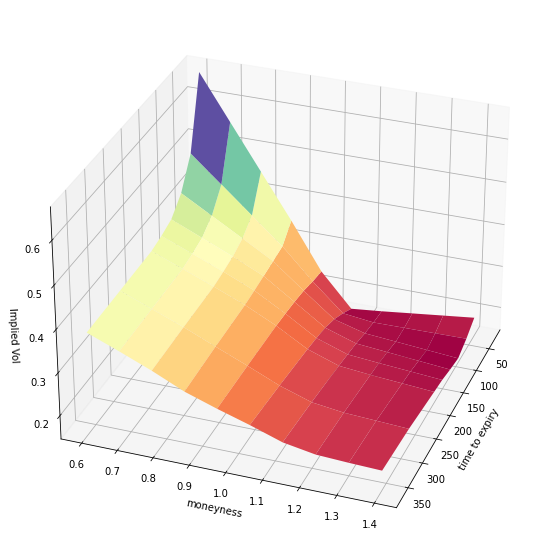

In [81]:
#create surface

tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
v=pd.pivot(interpolated_df,index=['moneyness'],columns=['days'],values='impl_volatility').to_numpy()
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,v,cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('Implied Vol')
ax.view_init(azim=20)
plt.show()

In [82]:
def interpolate_impliedvol(moneyness, tau, df):
    """
    Calculate implied volatility by linear interpolation first in moneyness and then time to maturity.
    
    Args:
    - moneyness (float): The moneyness value,
    - tau (float): The time to maturity,
    - df (pandas.DataFrame): The DataFrame containing the moneyness, tau, and impliedvol columns.
    
    Returns:
        float: The interpolated impliedvol value.
    """
    # Sort the DataFrame by moneyness and tau
    df_sorted = df.sort_values(['moneyness', 'tau'])
    
    # Interpolate in moneyness
    moneyness_values = df_sorted['moneyness'].unique()
    impliedvol_values = [df_sorted.loc[df_sorted['moneyness']==m, 'impliedvol'].values for m in moneyness_values]
    impliedvol_interp = pd.Series(impliedvol_values, index=moneyness_values).interpolate(method='linear')(moneyness)
    
    # Interpolate in tau
    tau_values = df_sorted['tau'].unique()
    impliedvol_values = [df_sorted.loc[df_sorted['tau']==t, 'impliedvol'].values for t in tau_values]
    impliedvol_interp = pd.Series(impliedvol_values, index=tau_values).interpolate(method='linear')(tau)
    
    return impliedvol_interp


In [83]:
#Next is to implement arbitrage penalties
pd.pivot(interpolated_df,index=['moneyness'],columns=['days'],values='impl_volatility')
interpolated_df

,date,days,impl_volatility,cp_flag,ticker,rate,moneyness
0,2021-12-31,30,0.662555,C,NDX,0.005311,0.600000
1,2021-12-31,30,0.557275,C,NDX,0.005311,0.688889
2,2021-12-31,30,0.451995,C,NDX,0.005311,0.777778
3,2021-12-31,30,0.346715,C,NDX,0.005311,0.866667
4,2021-12-31,30,0.235843,C,NDX,0.005311,0.955556
...,...,...,...,...,...,...,...
75,2021-12-31,365,0.236140,C,NDX,0.006907,1.044444
76,2021-12-31,365,0.211065,C,NDX,0.006907,1.133333
77,2021-12-31,365,0.198036,C,NDX,0.006907,1.222222
78,2021-12-31,365,0.194360,C,NDX,0.006907,1.311111


In [84]:
def c(m,tao,r,sigma):
    #calculate call price
    d1=(-np.log(m)+tao*(r+sigma**2/2))/(sigma*np.sqrt(tao))
    d2=(-np.log(m)+tao*(r-sigma**2/2))/(sigma*np.sqrt(tao))
    return norm.cdf(d1)-m*np.exp(-r*tao)*norm.cdf(d2)

#calendar spread arbitrage penalty
def p1(df,matrix=False):
    '''
    Takes an interpolated dataframe containing:
    'days' - days to expiry
    'impl_volatility' -implied volatility
    'rate' - interest rate
    'moneyness' - ratio of asset price and strike
    'c' - call price
    if matrix is true return the surface of p1
    '''
    df['time']=df['days']/365
    pivot_df=pd.pivot(df,index=['time'],columns=['moneyness'],values='c')
    pivot_df=pivot_df-pivot_df.shift(-1)
    time_diff=np.diff(pivot_df.index.to_numpy())
    
    pivot_df=pivot_df.iloc[:-1]
    #divide by time difference and multiply by time
    
    #in the paper for the sum they have mutliply by tj but not in the matrix version is this a typo?
    if(matrix):
        pivot_df=pivot_df.T/time_diff
        pivot_df=np.maximum(pivot_df,0)
        #insert boundary as 0's
        pivot_df.insert(len(pivot_df.columns),1,np.zeros(len(pivot_df.index)))
        return pivot_df
    else:
        pivot_df=pivot_df.T/time_diff*pivot_df.index
        pivot_df=np.maximum(pivot_df,0)
    
    #now sum across columns and rows
    p1=pivot_df.sum().sum()
    return p1

In [85]:
#call spread arbitrage penalty
def p2(df,matrix=False):
    '''
    Takes an interpolated dataframe containing:
    'days' - days to expiry
    'impl_volatility' -implied volatility
    'rate' - interest rate
    'moneyness' - ratio of asset price and strike
    'c' - call price
    if matrix is true return the surface of p1
    '''
    df['time']=df['days']/365
    max_m=max(df['moneyness'].unique())
    pivot_df=pd.pivot(df,index=['moneyness'],columns=['time'],values='c')
    pivot_df=pivot_df.shift(-1)-pivot_df
    money_diff=np.diff(pivot_df.index.to_numpy())
    pivot_df=pivot_df.iloc[:-1]
    #divide by difference in moneyness
    pivot_df=pivot_df.T/money_diff
    pivot_df=np.maximum(pivot_df,0)
    if(matrix):
        pivot_df.insert(len(pivot_df.columns),max_m,np.zeros(len(pivot_df.index)))
        return pivot_df.T
    else:
        return pivot_df.sum().sum()

In [86]:
#butterfly spread arbitrage penalty
def p3(df,matrix=False):
    '''
    Takes an interpolated dataframe containing:
    'days' - days to expiry
    'impl_volatility' -implied volatility
    'rate' - interest rate
    'moneyness' - ratio of asset price and strike
    'c' - call price
    if matrix is true return the surface of p1
    '''
    df['time']=df['days']/365
    
    #second term
    pivot_df=pd.pivot(df,index=['moneyness'],columns=['time'],values='c')
    df_1=pivot_df.shift(-1)-pivot_df
    money_diff=np.diff(pivot_df.index.to_numpy())
    df_1=df_1.iloc[:-1]
    df_1=df_1.T/money_diff
    
    #frist term
    df_2=pivot_df-pivot_df.shift(1)
    df_2=df_2.iloc[1:]
    df_2=df_2.T/money_diff
    
    df_3=df_2-df_1
    #df_3=df_3.iloc[:,1:-1]
    df_3=df_3.fillna(0)
    df_3=np.maximum(df_3,0)
    if(matrix):
        return df_3.T
    else:
        return df_3.sum().sum()

### Interpolating Interest Rates

In [87]:
#interpolate interest rates to work with volsurf_df
zero_curve

,date,days,rate
0,2000-01-03,7,0.059296
1,2000-01-03,16,0.059142
2,2000-01-03,44,0.060177
3,2000-01-03,72,0.060907
4,2000-01-03,107,0.061550
...,...,...,...
250023,2021-12-31,182,0.005868
250024,2021-12-31,273,0.006338
250025,2021-12-31,365,0.006907
250026,2021-12-31,547,0.008269


In [88]:
day_list=np.array([30,60,91,122,152,182,273,365])

In [89]:
#make a new dataframe with these days
dates=zero_curve['date'].unique()

rep_days=np.tile(day_list,len(dates))
rep_dates=np.repeat(dates,len(day_list))
df_to_merge=pd.DataFrame(np.vstack((rep_dates,rep_days)).T,columns=['date','days'])

#now merge dfs to make na's so we can interpolate
merged_df=pd.merge(zero_curve, df_to_merge, how='outer', on=['date','days'])
merged_df=merged_df.sort_values(['date','days'])
merged_df['days']=merged_df['days'].astype(int)
merged_df=merged_df.set_index(['days'])

for date in dates:
    merged_df[merged_df['date']==date]=merged_df[merged_df['date']==date].interpolate(method='spline',order=3)

C:\Users\david\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


In [90]:
interpolated_rates=merged_df

In [91]:
interpolated_rates=interpolated_rates.reset_index()

In [92]:
#add rates to volsurface dataframe
impl_vol_df=pd.merge(volsurf_df,interpolated_rates,how='left',left_on=['date','days'],right_on=['date','days'])

#some dates were not included in the zero_curve file, interpolate for these
for days in impl_vol_df['days'].unique():
    impl_vol_df[impl_vol_df['days']==days]=impl_vol_df[impl_vol_df['days']==days].interpolate(method='spline',order=3)

#calculate moneyness
impl_vol_df['moneyness']=impl_vol_df.apply(lambda x: inverse_delta(x.delta,x.days/365,x.rate,x.impl_volatility),axis=1)

Need to create a fixed grid for m, so that we can create a proper surface when calculating the arbitrage penalties

In [93]:
def interpolate_moneyness(df,m_grid):
    '''
    Takes as argument a dataframe with:
    days,moneyness,inpl_volatility columns, delta and c
    
    Returns:
    Dataframe with implied volatility values linearly interpolated to fit the gird of
    moneyness values
    '''
    #m_grid=np.linspace(0.6,1.4,10)
    t_grid=df['days'].unique()
    
    #interpolate in moneyness
    df=df.sort_values(['days','moneyness'])
    interpolated_points=[]
    interpolated_df=pd.DataFrame()
    
    for t in t_grid:
        sub_df=df[df['days']==t]
        #interpolation step
        interpolated_points=np.interp(m_grid,sub_df['moneyness'],sub_df['impl_volatility'])
        sub_df=sub_df[:10]
        #replace columns for new interpolated grid
        sub_df['moneyness']=m_grid
        sub_df['impl_volatility']=interpolated_points

        interpolated_df=pd.concat([interpolated_df,sub_df],ignore_index=True)
        interpolated_df.drop(columns=['delta'],inplace=True)
        #delta no longer accurate
    return interpolated_df

In [94]:
m_grid=np.linspace(0.6,1.4,10)
interp_implvol_df=pd.DataFrame([])

dates=impl_vol_df['date'].unique()
for date in dates:
    temp_df=impl_vol_df[impl_vol_df['date']==date]
    interp_implvol_df=pd.concat([interp_implvol_df,interpolate_moneyness(temp_df,m_grid)])

In [95]:
#now calculate call values
interp_implvol_df['c']=interp_implvol_df.apply(lambda row: c(row['moneyness'],row['days']/365,row['rate'],row['impl_volatility']),axis=1)

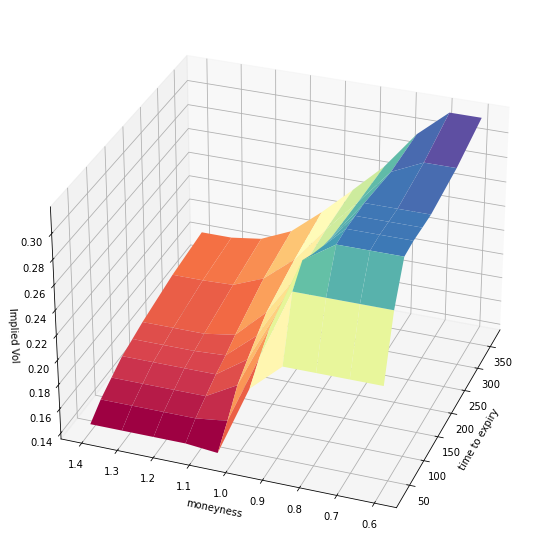

In [105]:
#with relevant interest rates can now consider date in paper

sample_df=interp_implvol_df[interp_implvol_df['date']=='2021-11-01']
m_grid=np.linspace(0.6,1.4,10)
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
v=pd.pivot(sample_df,index=['moneyness'],columns=['days'],values='impl_volatility').to_numpy()
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,v,cmap='Spectral')
ax.set_ylabel('Moneyness')
ax.set_xlabel('Time to expiry')
ax.set_zlabel('Implied Vol')
ax.view_init(azim=200)
plt.show()

### Assessing Arbitrage Penalties

In [96]:
p1_vals=interp_implvol_df.groupby('date').apply(p1)
p2_vals=interp_implvol_df.groupby('date').apply(p2)
p3_vals=interp_implvol_df.groupby('date').apply(p3)
ptot_vals=p1_vals+p3_vals+p2_vals

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


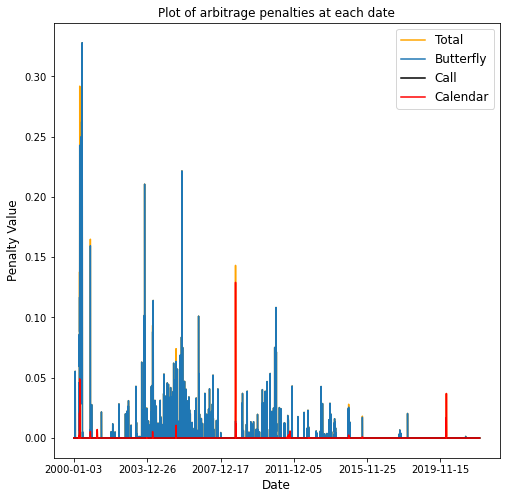

In [153]:
ptot_vals.plot(figsize=(8,8),label='Total',color='orange')
p3_vals.plot(figsize=(8,8),label='Butterfly')
p2_vals.plot(figsize=(8,8),label='Call',color='black')
p1_vals.plot(figsize=(8,8),label='Calendar',color='red')
plt.title("Plot of arbitrage penalties at each date",fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Penalty Value',fontsize=12)
plt.legend(fontsize=12)


In [154]:
test_sample=interp_implvol_df[interp_implvol_df['date']=='2008-10-09']

C:\Users\david\AppData\Local\Temp\ipykernel_15884\695296352.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time']=df['days']/365
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


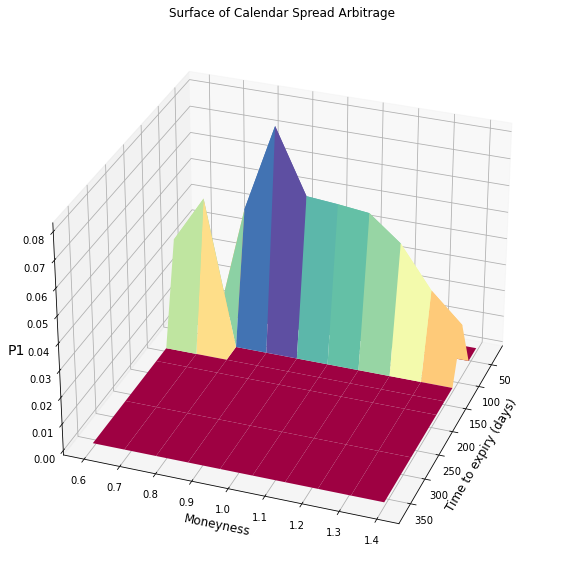

In [155]:
m_grid=np.linspace(0.6,1.4,10)
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,p1(test_sample,matrix=True).to_numpy(),cmap='Spectral')
ax.set_ylabel('Moneyness',fontsize=12)
ax.set_xlabel('Time to expiry (days)',fontsize=12)
ax.set_zlabel('P1',fontsize=14)
ax.view_init(azim=20)
plt.title("Surface of Calendar Spread Arbitrage",fontsize=12)
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_15884\1963606714.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time']=df['days']/365


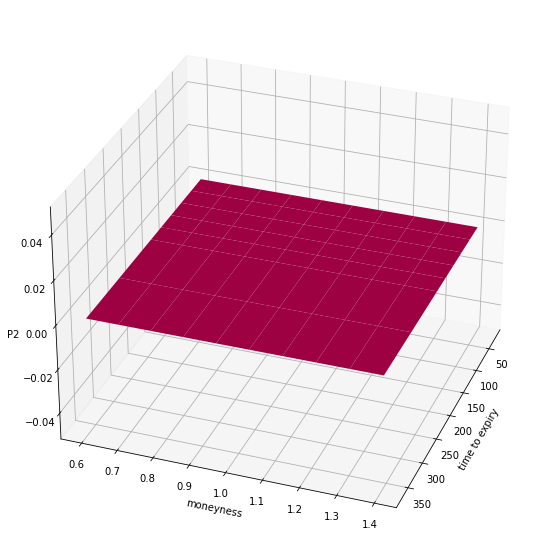

In [100]:
m_grid=np.linspace(0.6,1.4,10)
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,p2(test_sample,matrix=True).to_numpy(),cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('P2')
ax.view_init(azim=20)

plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_15884\2512577131.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time']=df['days']/365


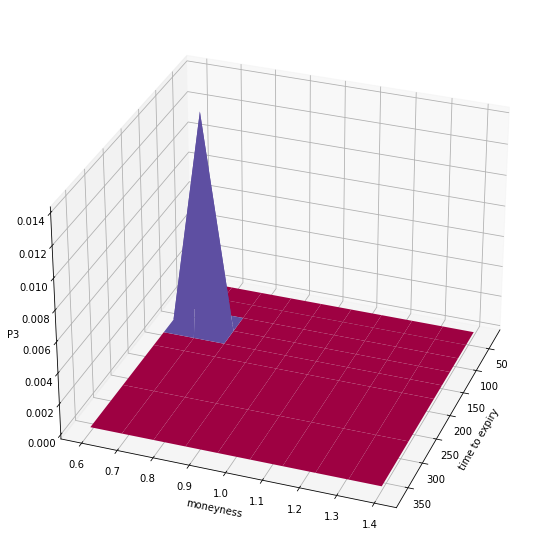

In [101]:
m_grid=np.linspace(0.6,1.4,10)
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,p3(test_sample,matrix=True).to_numpy(),cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('P3')
ax.view_init(azim=20)
plt.show()

Repeating the above on a smaller grid of $[0.8,1.2]$

In [117]:
m_grid=np.linspace(0.8,1.2,10)
interp_implvol_df2=pd.DataFrame([])

dates=impl_vol_df['date'].unique()
for date in dates:
    temp_df=impl_vol_df[impl_vol_df['date']==date]
    interp_implvol_df2=pd.concat([interp_implvol_df2,interpolate_moneyness(temp_df,m_grid)])

In [118]:
interp_implvol_df2['c']=interp_implvol_df2.apply(lambda row: c(row['moneyness'],row['days']/365,row['rate'],row['impl_volatility']),axis=1)

In [119]:
p1_vals=interp_implvol_df.groupby('date').apply(p1)
p2_vals=interp_implvol_df.groupby('date').apply(p2)
p3_vals=interp_implvol_df.groupby('date').apply(p3)
ptot_vals=p1_vals+p3_vals+p2_vals

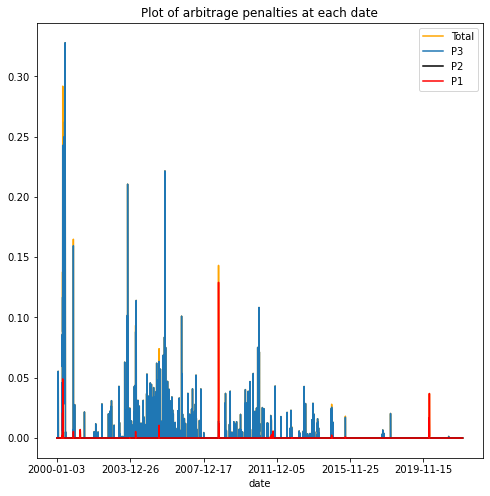

In [120]:
ptot_vals.plot(figsize=(8,8),label='Total',color='orange')
p3_vals.plot(figsize=(8,8),label='P3')
p2_vals.plot(figsize=(8,8),label='P2',color='black')
p1_vals.plot(figsize=(8,8),label='P1',color='red')
plt.title("Plot of arbitrage penalties at each date")

plt.legend()

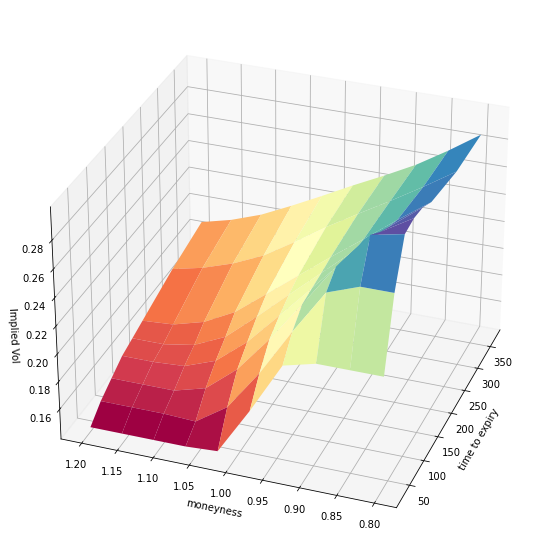

In [121]:
sample_df=interp_implvol_df2[interp_implvol_df2['date']=='2021-11-01']
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
v=pd.pivot(sample_df,index=['moneyness'],columns=['days'],values='impl_volatility').to_numpy()
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,v,cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('Implied Vol')
ax.view_init(azim=200)
plt.show()

## NW Smoothing

In [122]:
def NWSmooth(df,t,h1,h2,m,tau):
    '''
    Arguments:
    df-dataframe
    t-desired date
    h1,h2-bandwith parameters
    m-moneyness value desired
    tau-time to expiry desired in years
    
    returns:
    volatility value on NW-Smoothed plane at that time
    '''
    m_grid=df['moneyness'].unique()
    t_grid=df['days'].unique()
    t_grid=t_grid/365
    df_t=df[df['date']==t]
    g=lambda x,y:1/(2*np.pi)*np.exp(-x**2/(2*h1))*np.exp(-y**2/(2*h2))
    df_t['time']=df_t['days']/365
    pivot_df=pd.pivot(df_t,index=['moneyness'],columns=['time'],values='impl_volatility')
    g_vals=np.zeros([len(m_grid),len(t_grid)])
    for i,m_val in enumerate(m_grid):
        for j,t_val in enumerate(t_grid):
            
            g_vals[i,j]=g(m-m_val,tau-t_val)
    
    g_vals=g_vals
    pivot_df=pivot_df*g_vals
    return pivot_df.sum().sum()/np.sum(g_vals)

## Volgan

Using a moneyness grid of [0.8,1.2]

In [123]:
returns=pd.read_csv("C:\\Users\\david\\Documents\\Topics in Quant finance\\data\\Nasdaq return data.csv")
realized_vol=pd.read_csv("C:\\Users\\david\\Documents\\Topics in Quant finance\\data\\Nasdaq Realized vol.csv")

In [124]:
realized_vol

,secid,date,days,volatility,cusip,index_flag
0,102480,2000-01-03,30,0.234448,12490H10,1
1,102480,2000-01-03,60,0.260605,12490H10,1
2,102480,2000-01-03,91,0.274575,12490H10,1
3,102480,2000-01-03,122,0.284508,12490H10,1
4,102480,2000-01-03,152,0.288484,12490H10,1
...,...,...,...,...,...,...
44283,102480,2021-12-31,122,0.179904,12490H10,1
44284,102480,2021-12-31,152,0.166835,12490H10,1
44285,102480,2021-12-31,182,0.159198,12490H10,1
44286,102480,2021-12-31,273,0.158909,12490H10,1


In [125]:
returns.drop(columns=['low','secid'],inplace=True)
realized_vol.drop(columns=['secid','cusip','index_flag'],inplace=True)

It should be noted that in the model described in the paper they take only one realized volatility at any date, or so it seems at least, it is not entirely clear. But from the data above we are able to access realized volatilities based on different periods that match up with the times to expiry. By using only one realized vol is this not implicitly training the gan to think that volatility is independent of time?

If there is a problem with this we can simply replace it with the 30 day measurement

In [126]:
#since this is a conditional gan we also need to know the labels or the condition size
#labels are return one step before, returns,realized vol, log implied vol grid
m=len(interp_implvol_df2['moneyness'].unique())
n=len(interp_implvol_df2['days'].unique())
num_labels=2+(m+1)*n

#architecture of the generator
generator=keras.Sequential([
    keras.layers.InputLayer(input_shape=(16+num_labels,)),
    keras.layers.Dense(8,activation='softplus'),
    keras.layers.Dense(16,activation='softplus'),
    keras.layers.Dense((1+m*n),activation='linear') #outputs return and surface
],name='generator')

#architecture of the discriminator
discriminator=keras.Sequential([
    keras.layers.InputLayer(input_shape=(1+m*n+num_labels,)),
    keras.layers.Dense(16,activation='softplus'),
    keras.layers.Dense(1,activation='sigmoid')
],name='discriminator')

In [127]:
#gathering the input data
#make the condition data frame
#add returns at each date, including shifted returns
returns['rt-1']=returns['return'].shift(1)
gan_input=pd.merge(interp_implvol_df2,returns,how='left',left_on=['date'],right_on=['date'])

#now add realized vol for each day,date combination
gan_input=pd.merge(gan_input,realized_vol,how='left',left_on=['date','days'],right_on=['date','days'])
gan_input.rename(columns={'volatility':'realized_vol'},inplace=True)

#get the log volatility
gan_input['log_impl_vol']=np.log(gan_input['impl_volatility'])

#keep necessary columns
gan_input=gan_input[['date','days','moneyness','return','rt-1','realized_vol','log_impl_vol']]
gan_input['log_vol_diff']=gan_input.groupby(['moneyness','days']).log_impl_vol.diff()
#drop initial date as dont have previous time returns for this
gan_input=gan_input[gan_input['date']>'2000-01-03']

In [128]:
#split the dates for testing and training
dates=gan_input['date'].unique()
train_dates=dates[np.where(dates<='2017-12-31')]
test_dates=dates[np.where(dates>'2017-12-31')]

condition_train=np.zeros([(len(train_dates)-1),num_labels])
real_data_train=np.zeros([(len(train_dates)-1),m*n+1]) #inlcudes vol surface and return

condition_test=np.zeros([(len(test_dates)-1),num_labels])
real_data_test=np.zeros([(len(test_dates)-1),m*n+1])

In [129]:

#fill the condition array to be used for the gan all but the last date are used for t-1
for i,date in enumerate(train_dates[:-1]):
    sub_df=gan_input[gan_input['date']==date]
    condition_train[i,10:]=sub_df.log_impl_vol # flattened array iterates through moneyness then increments time
    condition_train[i,0]=sub_df['rt-1'].unique()
    condition_train[i,1:9]=sub_df.groupby('days').agg({"realized_vol":lambda x:list(x)[0]}).to_numpy().flatten()
    #for some reason .unique() fails to return values a certain points
    condition_train[i,9]=sub_df['return'].unique()
    
for i,date in enumerate(test_dates[:-1]):
    sub_df=gan_input[gan_input['date']==date]
    condition_test[i,10:]=sub_df.log_impl_vol # flattened array iterates through moneyness then increments time
    condition_test[i,0]=sub_df['rt-1'].unique()
    condition_test[i,1:9]=sub_df.groupby('days').agg({"realized_vol":lambda x:list(x)[0]}).to_numpy().flatten()
    #for some reason .unique() fails to return values a certain points
    condition_test[i,9]=sub_df['return'].unique()

In [130]:
#repeat for actual data at time t, all but the first date are used
for i,date in enumerate(train_dates[1:]):
    sub_df=gan_input[gan_input['date']==date]
    real_data_train[i,1:]=sub_df.log_vol_diff
    
    real_data_train[i,0]=sub_df['return'].unique()
    
for i,date in enumerate(test_dates[1:]):
    sub_df=gan_input[gan_input['date']==date]
    real_data_test[i,1:]=sub_df.log_vol_diff
    real_data_test[i,0]=sub_df['return'].unique()

In [131]:
#conditional gan input and shuffle

batch_size=64
real_data_train=real_data_train.astype("float32")
condition_train=condition_train.astype("float32")
train_dataset=tf.data.Dataset.from_tensor_slices((real_data_train, condition_train)) #nicely zips data and labels
train_dataset=train_dataset.shuffle(1024).batch(batch_size) #shuffle the data

real_data_test=real_data_test.astype("float32")
condition_test=condition_test.astype("float32")
test_dataset=tf.data.Dataset.from_tensor_slices((real_data_test, condition_test)) #nicely zips data and labels

#list(dataset.as_numpy_iterator())

In [132]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim #number of noise data points =16
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        #this is for a single batch
        # Unpack the data.
        real_data, conditions = data

        
        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_data)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, conditions], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_volsurf = self.generator(random_vector_labels)
        # Combine them with real data. Note that we are concatenating the labels
        # with these volsurfs here.
        fake_volsurf_and_labels = tf.concat([generated_volsurf, conditions], -1)
        real_volsurf_and_labels = tf.concat([real_data, conditions], -1)
        combined = tf.concat(
            [fake_volsurf_and_labels, real_volsurf_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, conditions], axis=1
        )

        # Assemble labels that say "all real surfaces".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_volsurf = self.generator(random_vector_labels)
            fake_volsurf_and_labels = tf.concat([fake_volsurf, conditions], -1)
            predictions = self.discriminator(fake_volsurf_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [133]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=16
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

cond_gan.fit(train_dataset, epochs=30)

Epoch 1/30
71/71 [==============================] - 2s 2ms/step - g_loss: 0.6037 - d_loss: 0.8190
Epoch 2/30
71/71 [==============================] - 0s 6ms/step - g_loss: 0.8448 - d_loss: 0.5273
Epoch 3/30
71/71 [==============================] - 0s 5ms/step - g_loss: 0.6569 - d_loss: 0.7574
Epoch 4/30
71/71 [==============================] - 0s 5ms/step - g_loss: 0.8567 - d_loss: 0.5676
Epoch 5/30
71/71 [==============================] - 0s 5ms/step - g_loss: 0.7094 - d_loss: 0.6766
Epoch 6/30
71/71 [==============================] - 0s 5ms/step - g_loss: 0.6976 - d_loss: 0.6961
Epoch 7/30
71/71 [==============================] - 0s 5ms/step - g_loss: 0.7041 - d_loss: 0.7023
Epoch 8/30
71/71 [==============================] - 0s 5ms/step - g_loss: 0.6524 - d_loss: 0.8637
Epoch 9/30
71/71 [==============================] - 0s 5ms/step - g_loss: 0.9918 - d_loss: 0.5619
Epoch 10/30
71/71 [==============================] - 0s 5ms/step - g_loss: 0.5898 - d_loss: 0.9227
Epoch 11/30
71/71 [

In [134]:
trained_gen=cond_gan.generator
trained_disc=cond_gan.discriminator
trained_disc.predict(tf.concat([real_data_test,condition_test],axis=1))

32/32 [==============================] - 0s 2ms/step


array([[0.5256521 ],
       [0.5118665 ],
       [0.53953797],
       ...,
       [0.49230823],
       [0.5270705 ],
       [0.5073477 ]], dtype=float32)

1/1 [==============================] - 0s 94ms/step


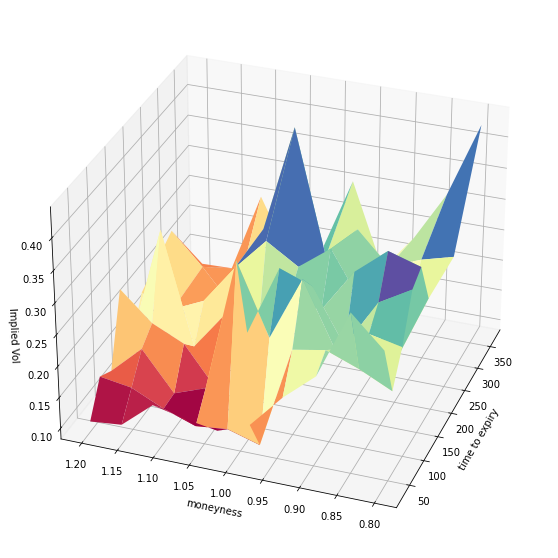

In [135]:
#test against vol surf on 2021-11-01
sample_condition=condition_test[np.where(test_dates=='2021-11-01')] 
sample_condition=np.reshape(sample_condition,90)
noise=np.random.normal(0,1,16)
generator_input=np.hstack([noise,sample_condition])
fake_log_vol_diff=trained_gen.predict(np.reshape(generator_input,(1,106)))
fake_log_vol_diff=fake_log_vol_diff[0,1:] #the first element is the return estimate
#this is now the log difference between implied vols at t and t-1

fake_log_vol_diff=np.reshape(fake_log_vol_diff,(n,m)).T
#add the difference to the vol surface from t-1
real_vol_df=gan_input[gan_input['date']=='2021-10-29']
real_log_vol=pd.pivot(real_vol_df,index=['moneyness'],columns=['days'],values='log_impl_vol')
fake_log_vol=real_log_vol+fake_log_vol_diff     
#expontentiate the log to find the actual vol
fake_vol=np.exp(fake_log_vol)

#plot the vol sruface
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
v=fake_vol
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,v,cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('Implied Vol')
ax.view_init(azim=200)
plt.show()

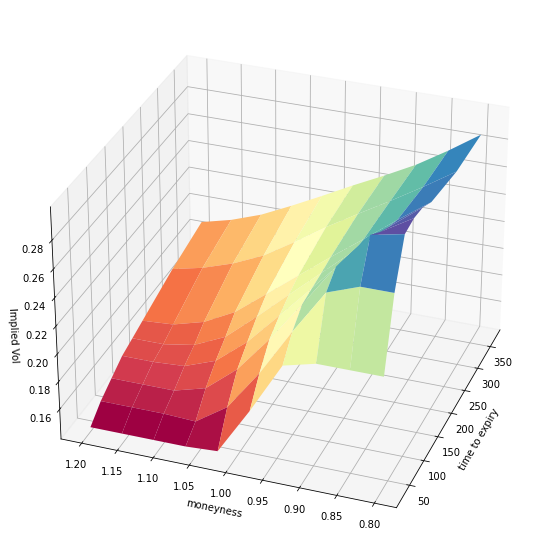

In [136]:
sample_df=interp_implvol_df2[interp_implvol_df2['date']=='2021-11-01']
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
v=pd.pivot(sample_df,index=['moneyness'],columns=['days'],values='impl_volatility').to_numpy()
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,v,cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('Implied Vol')
ax.view_init(azim=200)
plt.show()

### Calculate arbitrage penalties

In [137]:
#construct necessary dataframe

M,N = fake_vol.shape
data = {
    "impl_volatility": fake_vol.to_numpy().ravel("F"),
    "days": np.asarray(fake_vol.columns).repeat(M),
    "moneyness": np.tile(np.asarray(fake_vol.index), N),
}
fake_vol=pd.DataFrame(data, columns=["days", "moneyness", "impl_volatility"])

#reuse rates data
sub_df=interp_implvol_df2[interp_implvol_df2['date']=='2021-11-01']
fake_vol['date']=sub_df['date']
fake_vol['rate']=sub_df['rate']

#now get call values based on these vols
#now calculate call values
fake_vol['c']=fake_vol.apply(lambda row: c(row['moneyness'],row['days']/365,row['rate'],row['impl_volatility']),axis=1)

In [138]:
#now calculate arbitrage penalties
print('p1=',p1(fake_vol))
print('p2=',p2(fake_vol))
print('p3=',p3(fake_vol))

p1= 1.0188197344671157
p2= 3.211340724205058
p3= 14.040326118154846


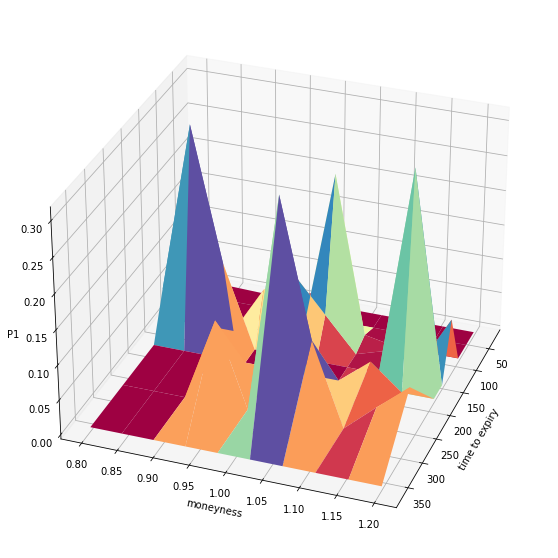

In [139]:
m_grid=np.linspace(0.8,1.2,10)
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,p1(fake_vol,matrix=True).to_numpy(),cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('P1')
ax.view_init(azim=20)
plt.show()

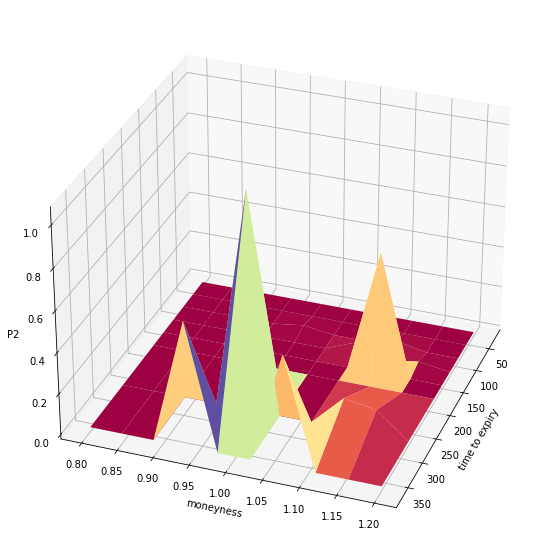

In [140]:
m_grid=np.linspace(0.8,1.2,10)
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,p2(fake_vol,matrix=True).to_numpy(),cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('P2')
ax.view_init(azim=20)
plt.show()

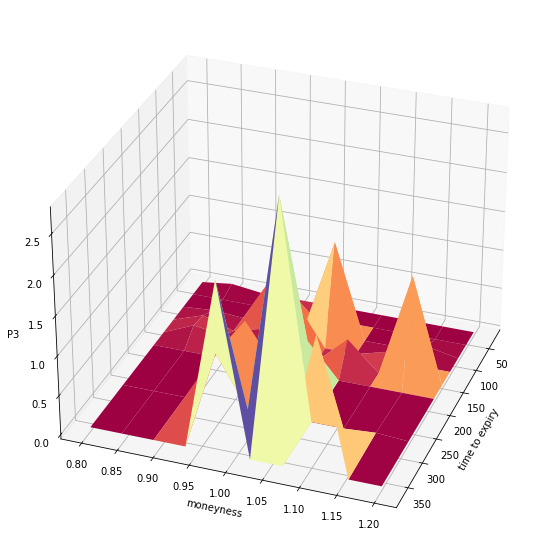

In [141]:
m_grid=np.linspace(0.8,1.2,10)
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,p3(fake_vol,matrix=True).to_numpy(),cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('P3')
ax.view_init(azim=20)
plt.show()

0.015887009752785647
0.0
0.4316800231936335


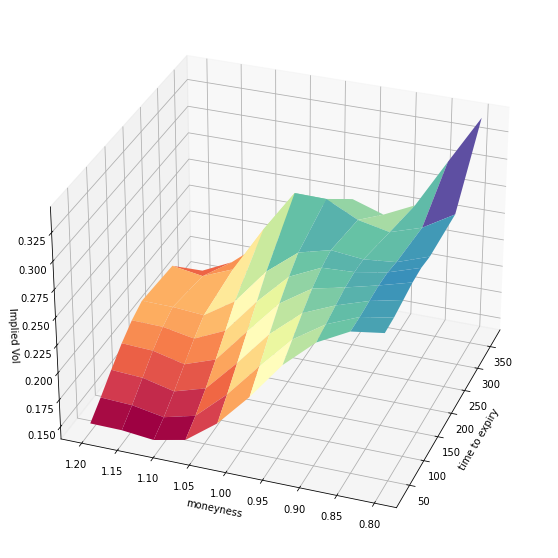

In [142]:
#try smoothing our generated vol surface

smooth_fake_vol=[]
smooth_fake_vol_df=fake_vol.copy(deep=True)

for t_j in t_grid:
    for m_i in m_grid:
        smooth_fake_vol.append(NWSmooth(fake_vol,'2021-11-01',0.002,0.03,m_i,t_j/365))

smooth_fake_vol_df=fake_vol
smooth_fake_vol_df['impl_volatility']=smooth_fake_vol
smooth_fake_vol_df['c']=smooth_fake_vol_df.apply(lambda row: c(row['moneyness'],row['days']/365,row['rate'],row['impl_volatility']),axis=1)


print(p1(smooth_fake_vol_df))
print(p2(smooth_fake_vol_df))
print(p3(smooth_fake_vol_df))

#plot the vol sruface
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
v=pd.pivot(smooth_fake_vol_df,index=['moneyness'],columns=['days'],values='impl_volatility').to_numpy()
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,v,cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('Implied Vol')
ax.view_init(azim=200)
plt.show()